In [1]:
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.debugger import set_trace

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
from pathlib import Path
import glob
import regex
import dill
import gzip
import toolz, itertools, more_itertools
from collections import Counter, OrderedDict

In [6]:
import optuna
import sklearn

In [7]:
import math
import pandas as pd 
import numpy as np
import seaborn as sns
from imblearn.combine import SMOTETomek
import statistics
import shap
np.random.seed(42)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## DATA directory
Note: Please change the DIR path accordingly  

In [8]:
DIR = Path(r'C:\Users\Abhij\OneDrive\Documents\GitHub\DNA-structure-prediction')
os.chdir(DIR)
assert DIR.exists()
DATA = DIR/"data"

## Helper Functions to read pickled data

In [9]:
def make_dirs(*, name: str) -> ():
    try:
        _file = DIR / "data"
        os.mkdir(_file / name)
    except FileExistsError:
        print("Dir exists")


def pkl_it(dataframe, filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "wb") as fh:
        dill.dump(dataframe, fh)
    return


def unpkl_it(filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "rb") as fh:
        return dill.load(fh)

make_dirs(name="results")
make_dirs(name="pkl")

Dir exists
Dir exists


## A flexible helper Class for running different ML algorithms  
It automatically chooses the best threshold for classification by locating the arg_max (index) of the best F-score  

In [10]:
import logging
from collections import defaultdict
logging.basicConfig(filename=DATA/'results.log', level=logging.INFO)
from utils.Evaluator import Call_Plot 


## Read curated dataset

In [11]:
curated_data = unpkl_it("curated_dataset")
curated_data

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6F3C,0,CGTACG,0,0,2,0,0,1,0,0,2,0,B
6GIM,0,AAATTT,4,0,0,0,1,0,0,0,0,0,B
6ASF,0,CCAAGATAG,1,1,0,1,1,1,2,1,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117D,1,GCGTACGTACGC,0,0,4,0,0,2,0,0,3,2,A
118D,1,GTGCGCAC,0,0,2,2,0,0,0,0,1,2,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A


In [12]:
#Check if any sequence has duplicate features
curated_data.drop_duplicates(subset=['AA/TT', 'GG/CC', 'AC/GT',
                                          'CA/TG', 'AT/AT', 'TA/TA', 'AG/CT', 'GA/TC', 'CG/CG', 'GC/GC'], keep='last')

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6F3C,0,CGTACG,0,0,2,0,0,1,0,0,2,0,B
6GIM,0,AAATTT,4,0,0,0,1,0,0,0,0,0,B
6ASF,0,CCAAGATAG,1,1,0,1,1,1,2,1,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117D,1,GCGTACGTACGC,0,0,4,0,0,2,0,0,3,2,A
118D,1,GTGCGCAC,0,0,2,2,0,0,0,0,1,2,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A


## Nested Cross-validation

In [13]:
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import RepeatedStratifiedKFold

from utils.NestedCV import gen_data, gen_data_for_tuningHP

The function gen_data is a flexible generator that implements outer fold of Nested CV  
Here, we are using 5-fold stratified Nested cross validation (n_splits = 5)  

This generator implements inner fold of Nested CV, where we tune hyperparameters.

## Helper function: train_test_folds_reader

In [14]:

def train_test_folds_reader(*, folder) -> dict:
    TRAIN_TEST = Path(folder)
    for i in range(5):
        yield {"X_train": pd.read_excel(folder/f"train_fold_{i+1}.xls", index_col=0).drop(labels=["target", "sequence", "item"], axis=1),
               "y_train": pd.read_excel(folder/f"train_fold_{i+1}.xls", index_col=0)["target"],
               "X_val":   pd.read_excel(folder/f"test_fold_{i+1}.xls", index_col=0).drop(labels=["target", "sequence", "item"], axis=1),
               "y_val":   pd.read_excel(folder/f"test_fold_{i+1}.xls", index_col=0)["target"],}

## Read the best Random Forest hyperparameters

In [16]:
best_RF_params = pd.read_csv(DATA/"tuned_hyperparameters"/"best_RF_params.csv", index_col=0)

In [17]:
best_RF_params

,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
Model_1,True,0.0,NaN,gini,15,auto,NaN,NaN,0.0,NaN,0.2,0.4,0.0,110,-1,False,42,0,False
Model_2,True,0.0,NaN,gini,13,auto,NaN,NaN,0.0,NaN,0.2,0.3,0.0,120,-1,False,42,0,False
Model_3,True,0.0,NaN,gini,19,sqrt,NaN,NaN,0.0,NaN,0.2,0.1,0.0,460,-1,False,42,0,False
Model_4,True,0.0,NaN,gini,22,sqrt,NaN,NaN,0.0,NaN,0.2,0.3,0.0,160,-1,False,42,0,False
Model_5,True,0.0,NaN,gini,13,auto,NaN,NaN,0.0,NaN,0.1,0.3,0.0,220,-1,False,42,0,False


## Set up Random Forest training

In [18]:
#Class weight factor:
SCALE_POS_WEIGHT = lambda T,P: (100*(T-P)/T) / (100*P/T)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
import optuna
from optuna.pruners import HyperbandPruner
import copy

In [20]:
def trainer(data, param_updater):
    
    train_x, train_y = data["X_train"], data["y_train"]
    
    param = {
        "n_jobs": -1,
        "random_state": 42,
        "verbose": 0,
        "bootstrap": True,
    }
    param.update(param_updater)
    model = RandomForestClassifier(**param)
    model.fit(train_x, train_y)
    return model




## Train, Run and evaluate performance of Random Forest using tuned hyperparameters

<IPython.core.display.Javascript object>


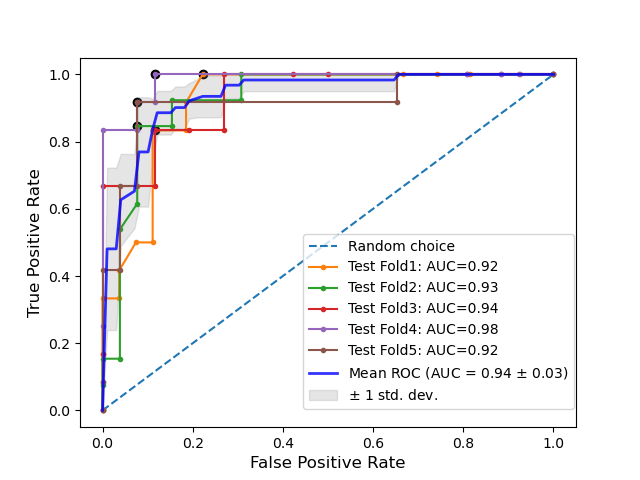

<IPython.core.display.Javascript object>


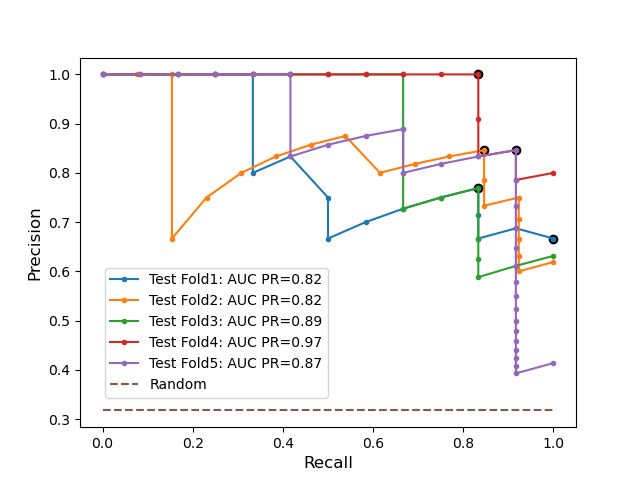

              precision    recall  f1-score   support

       B-DNA       0.96      0.81      0.88        27
       A-DNA       0.69      0.92      0.79        12

    accuracy                           0.85        39
   macro avg       0.82      0.87      0.83        39
weighted avg       0.87      0.85      0.85        39

Average PR:  0.823666958041958
AUC PR:  0.8214767871017871
Best Threshold_f-score=0.349370, F-Score=0.800
AUC:  0.9228395061728395
Best Threshold_ROC=0.349370, G-Mean_ROC=0.882
Accuracy:  0.8461538461538461
F1:  0.7857142857142857
MCC:  0.6863599462712044
              precision    recall  f1-score   support

       B-DNA       0.89      0.92      0.91        26
       A-DNA       0.83      0.77      0.80        13

    accuracy                           0.87        39
   macro avg       0.86      0.85      0.85        39
weighted avg       0.87      0.87      0.87        39

Average PR:  0.829399446707139
AUC PR:  0.8211224672763133
Best Threshold_f-score=0.415092

In [24]:
plt.close()
# *************OUTER*************
plot_Model_RF_test = Call_Plot(repeated_k_fold=False, model_name="RF", DIR=DIR)
for outer_idx, elem in enumerate(train_test_folds_reader(folder=DATA/"train_test_folds")):
    # ***********INNER************
    model = trainer(elem, best_RF_params.dropna(how="any", axis=1).T.to_dict()
                    [f"Model_{outer_idx + 1}"])
    plot_Model_RF_test.Plot(elem, model, outer_idx)
plot_Model_RF_test.post_Plot()

In [25]:
pd.DataFrame(plot_Model_RF_test.results)

,Average PR,AUC PR,ROC AUC,Accuracy,F1,MCC,cohen_kappa_score
0,0.823667,0.821477,0.922840,0.846154,0.785714,0.686360,0.669492
1,0.829399,0.821122,0.927515,0.871795,0.800000,0.707107,0.705882
2,0.896827,0.893272,0.935897,0.842105,0.750000,0.634615,0.634615
3,0.970513,0.969383,0.983974,0.921053,0.857143,0.820008,0.804124
4,0.877708,0.872598,0.916667,0.894737,0.833333,0.756410,0.756410


In [26]:
pd.DataFrame(plot_Model_RF_test.results).mean()

Average PR           0.879623
AUC PR               0.875571
ROC AUC              0.937379
Accuracy             0.875169
F1                   0.805238
MCC                  0.720900
cohen_kappa_score    0.714105
dtype: float64

## Running from scratch - Run and evaluate performance of Random Forest under 5-fold stratified Nested CV

In [29]:
import optuna

import copy

def objective(data, trial):
    train_x, valid_x, train_y, valid_y = data["X_train"], data["X_val"], data["y_train"], data["y_val"]


    param = {
        #"criterion": trial.suggest_categorical("criterion",["gini", "entropy"]),
        "n_estimators": trial.suggest_int("n_estimators", 10, 500, 10),
        "max_depth": trial.suggest_int("max_depth", 1, 32),
        "max_features": trial.suggest_categorical("max_features",["auto", "sqrt", "log2"]),
        "min_samples_split": trial.suggest_discrete_uniform("min_samples_split", 0.1, 1.0, 0.1),
        "min_samples_leaf": trial.suggest_discrete_uniform("min_samples_leaf", 0.1, 0.5, 0.1),
        "n_jobs": -1,
        "random_state": 42,
        "verbose": 0,
        "bootstrap": True,
        "class_weight": "balanced",
        
    }
    
    model = RandomForestClassifier(**param)
    model.fit(train_x, train_y)
    return sklearn.metrics.roc_auc_score(valid_y, model.predict(valid_x))




In [30]:
import collections
Trial = collections.namedtuple("Trial",["value", "parameters"])

<IPython.core.display.Javascript object>


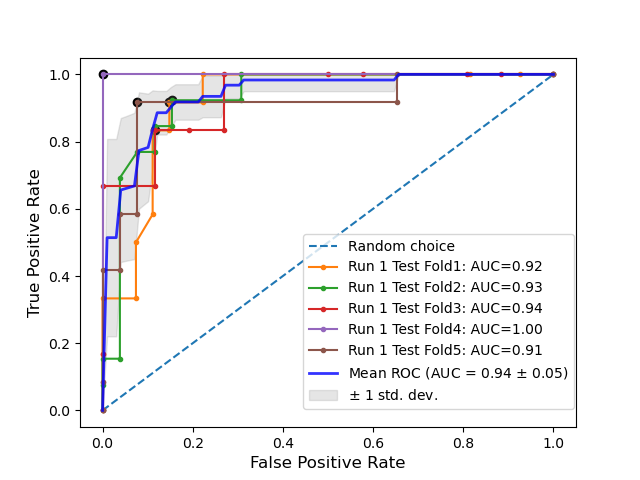

<IPython.core.display.Javascript object>


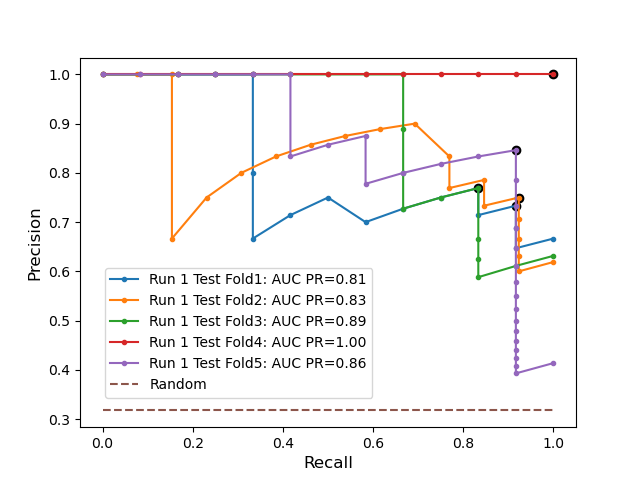

              precision    recall  f1-score   support

       B-DNA       0.92      0.85      0.88        27
       A-DNA       0.71      0.83      0.77        12

    accuracy                           0.85        39
   macro avg       0.82      0.84      0.83        39
weighted avg       0.86      0.85      0.85        39

Average PR:  0.8175657675657675
AUC PR:  0.8116816190345602
Best Threshold_f-score=0.354436, F-Score=0.815
AUC:  0.9212962962962963
Best Threshold_ROC=0.354436, G-Mean_ROC=0.884
Accuracy:  0.8461538461538461
F1:  0.7692307692307692
MCC:  0.6592443967173135
              precision    recall  f1-score   support

       B-DNA       0.92      0.85      0.88        26
       A-DNA       0.73      0.85      0.79        13

    accuracy                           0.85        39
   macro avg       0.82      0.85      0.83        39
weighted avg       0.86      0.85      0.85        39

Average PR:  0.8378815628815628
AUC PR:  0.8294636986944679
Best Threshold_f-score=0.3762

In [31]:
plt.close()
optuna.logging.set_verbosity(optuna.logging.WARNING)
results = []
outer_models = {}
best_models_RF = {}

# *************OUTER*************
plot_Model_RF = Call_Plot(sklearn_model=True, model_name="RF", repeated_k_fold=True, DIR=DIR)
for outer_idx, elem in enumerate(gen_data(curated_data.drop(labels=["item", "sequence"], axis=1), RESAMPLING = False)):
    
    study_dict = {}
    # ***********INNER************
    for idx, data_in in enumerate(gen_data_for_tuningHP(elem, RESAMPLING=False)):
        
        study = optuna.create_study(pruner=HyperbandPruner(max_resource="auto"),
                            direction="maximize")
        study.optimize((toolz.curry(objective)(data_in)), n_trials=100)

        #print("Number of finished trials: {}".format(len(study.trials)))

        trial = study.best_trial
        study_dict[idx] = Trial(trial.value, trial.params)
    arg_max = max(study_dict, key=lambda d: study_dict[d].value) #max for AUC
    best_models_RF[outer_idx] = trainer(elem, study_dict[arg_max].parameters)
    
    plot_Model_RF.Plot(elem, best_models_RF[outer_idx], outer_idx)
plot_Model_RF.post_Plot()


In [82]:
pd.DataFrame(plot_Model_RF_test.results)

,Average PR,AUC PR,ROC AUC,Accuracy,F1,MCC,cohen_kappa_score
0,0.910844,0.907099,0.950617,0.897436,0.818182,0.753599,0.747573
1,0.816082,0.807075,0.887574,0.846154,0.727273,0.645497,0.625000
2,0.960970,0.959510,0.977564,0.921053,0.869565,0.814697,0.813115
3,0.966346,0.965118,0.980769,0.921053,0.857143,0.820008,0.804124
4,0.896601,0.892854,0.929487,0.894737,0.833333,0.756410,0.756410


In [32]:
pd.DataFrame(plot_Model_RF_test.results).mean()

Average PR           0.879623
AUC PR               0.875571
ROC AUC              0.937379
Accuracy             0.875169
F1                   0.805238
MCC                  0.720900
cohen_kappa_score    0.714105
dtype: float64